In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools

In [3]:
using BAT 

# High `p` Population: 

In [5]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-1.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2");
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


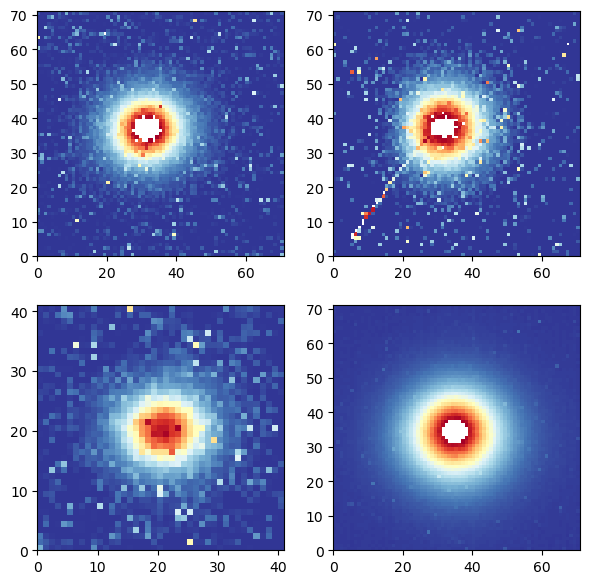

PyObject <matplotlib.collections.QuadMesh object at 0x7f81da34dfa0>

In [6]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [27]:
# include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

In [32]:

function likelihood_cam4(
        params::NamedTuple, 
        image::Array{F,2},
        population::AbstractFloat,
        cam_ind::Integer;
        n_threads::Integer = Threads.nthreads()
    ) where {F <: AbstractFloat}
   

    VT = eltype(params.tr_size)
    tot_loglik::Array{VT} = zeros(VT, n_threads)    
    light_coefficient::VT = params.cam4_light_amp * 10^5
    
    δ_x::VT = params.cam4_psx * 10^-3
    δ_y::VT = params.cam4_psy * 10^-3
    
    @inbounds μ_x::VT  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1::VT = sqrt(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2)
    @inbounds σ_y_1::VT = sqrt(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2)
    
    σ_x::VT = sqrt(σ_x_1^2 + (params.cam4_resx*δ_x)^2)
    σ_y::VT = sqrt(σ_y_1^2 + (params.cam4_resy*δ_y)^2)
    
    Threads.@threads for t in eachindex(tot_loglik)
        
        cum_log_lik = zero(Float64) 
        
        @inbounds for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            @inbounds if !isnan(image[pix_ind])
                
                @inbounds x_edge = pix_ind.I[1] * δ_x
                @inbounds y_edge = pix_ind.I[2] * δ_y

                right_tmp, left_tmp = pdf(Normal(μ_x,σ_x), x_edge), pdf(Normal(μ_x,σ_x), x_edge - δ_x)
                pix_prediction = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(Normal(μ_y,σ_y), y_edge), pdf(Normal(μ_y,σ_y), y_edge - δ_y)
                pix_prediction *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y
                
                pix_prediction = pix_prediction*light_coefficient + params.cam4_ped
                
                
                @inbounds cum_log_lik += logpdf(Normal(pix_prediction, params.cam4_light_fluct*sqrt(pix_prediction)), image[pix_ind]) # significantly speeds up auto diff
                
            end
        end
        
        @inbounds tot_loglik[t] = cum_log_lik
    end
    return sum(tot_loglik)
end


function likelihood_cam13(
        params::NamedTuple, 
        image::Array{F,2},
        population::AbstractFloat,
        cv_matrix::Array{C,2},
        cv_func::Function, 
        cam_ind::Integer;
        n_threads::Integer = Threads.nthreads()
    ) where {F <: AbstractFloat, C <: AbstractFloat}
    
    VT = eltype(params.tr_size)
    tot_loglik::Array{VT} = zeros(VT, n_threads)    
    
    light_coefficient::VT = params.light_amp[cam_ind] * 10^5
    
    δ_x::VT = params.psx[cam_ind] * 10^-3
    δ_y::VT = params.psy[cam_ind] * 10^-3
    
    @inbounds μ_x::VT  = params.algmx[cam_ind] * δ_x
    @inbounds μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    @inbounds σ_x_1::VT = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    @inbounds σ_y_1::VT = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x::VT = sqrt(σ_x_1^2 + (params.resx[cam_ind]*δ_x)^2)
    σ_y::VT = sqrt(σ_y_1^2 + (params.resy[cam_ind]*δ_y)^2) # \sigma x is the same for both
    
    Threads.@threads for t in eachindex(tot_loglik)
        
        cum_log_lik = zero(Float64)
        
        @inbounds for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            @inbounds if !isnan(image[pix_ind])
                
                @inbounds x_edge = pix_ind.I[1] * δ_x
                @inbounds y_edge = pix_ind.I[2] * δ_y

                right_tmp, left_tmp = pdf(Normal(μ_x,σ_x), x_edge), pdf(Normal(μ_x,σ_x), x_edge - δ_x)
                pix_prediction = (left_tmp + 0.5*(right_tmp - left_tmp))*δ_x
                right_tmp, left_tmp = pdf(Normal(μ_y,σ_y), y_edge), pdf(Normal(μ_y,σ_y), y_edge - δ_y)
                pix_prediction *= (left_tmp + 0.5*(right_tmp - left_tmp))*δ_y

                pix_prediction = pix_prediction*light_coefficient

                @inbounds cum_log_lik += logpdf(truncated(Normal(pix_prediction, params.light_fluct[cam_ind]*sqrt(pix_prediction)), 0.0, Inf), image[pix_ind]) 
            end
        end
        tot_loglik[t] = cum_log_lik
        
    end

    return sum(tot_loglik)
end

function conv_tabl_discrete(cv_matrix::Array{F,2}, observed::Real, expected::Real) where {F<:AbstractFloat}  
    return cv_matrix[convert(Integer, observed+1), round(Integer, expected+1)]     
end

conv_tabl_discrete (generic function with 1 method)

In [36]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik_ndiff()

#37 (generic function with 1 method)

In [52]:
# β = 0.015

β1 = 0.015
β2 = 0.008
β3 = 0.006

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        light_fluct = [1., 1., 1.,],
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
        cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); 

In [53]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 5000,
    max_nsteps_per_cycle = 5000,
    max_time_per_cycle = Inf,
    max_ncycles = 130
)

nsamples = 10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [54]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/s

1469.883419 seconds (659.69 M allocations: 374.183 GiB, 5.20% gc time)


In [55]:
samples = samples_tot.result;

In [56]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

3.0612614125045154

In [57]:
2788 / 60

46.46666666666667

In [58]:
size(flatview(unshaped.(samples.v)))

(35, 58607)

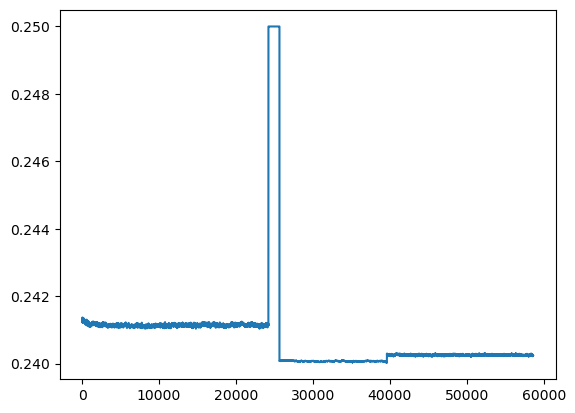

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f80a7a65850>

In [59]:
plot(flatview(unshaped.(samples.v))[1,:])

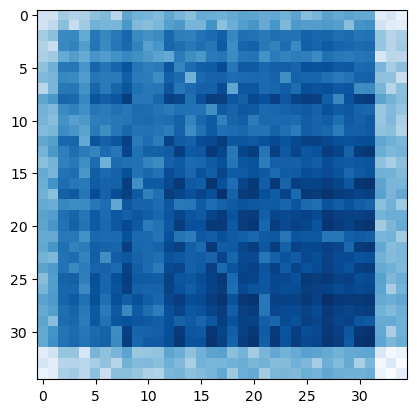

PyObject <matplotlib.image.AxesImage object at 0x7f8050da8e20>

In [60]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [61]:
# BAT.bat_write("../data/sampling_results/MultipleEvents-2/mcmc-samples-1-3.hdf5", unshaped.(samples))

# BAT.bat_write("tmp.hdf5", unshaped.(samples))

In [62]:
mode(samples)[1]

(tr_size = [0.24117447234385836, 0.24968613472869772], ang_spr = [5.8963735511692965, 5.53500822587064], waist = [2.88819938024259], algmx = [36.55078832383424, 34.44149692339507, 20.261018929237483, 31.066109384711538], algmy = [33.625525251401235, 32.18461411053137, 20.463484551720256, 35.219436618247705], cam4_ped = 27.055804417980486, cam4_light_fluct = 2.9999800421565443, cam4_light_amp = 8.53172869624691, light_fluct = [1.0, 1.0, 1.0], resx = [10.661939740233642, 9.71470210556667, 7.291261853752725], resy = [8.213875149723545, 2.449093932393309, 7.233732006991666], cam4_resx = 8.221979915392481, cam4_resy = 5.214017734189864, psx = [21.61417766049138, 17.683973122938102, 109.42326861900614], psy = [18.995249147199576, 15.071150556796264, 129.30552516089875], cam4_psx = 129.0518418340058, cam4_psy = 130.0576672283243, light_amp = [12.999999149635041, 16.99999912236017, 4.999944305160838], s_cam = [0.0, 1.478, 15.026, 23.115])

In [63]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.249975, 0.24257499999999999], ang_spr = [5.9990000000000006, 5.7725], waist = [2.9175], algmx = [36.905, 34.925, 20.064999999999998, 39.25], algmy = [36.55, 35.75, 18.270000000000003, 42.45], cam4_ped = 19.975, cam4_light_fluct = 2.965, cam4_light_amp = 6.925000000000001, light_fluct = [1.0, 1.0, 1.0], resx = [0.025, 14.45, 0.675], resy = [8.95, 6.925000000000001, 1.5750000000000002], cam4_resx = 0.825, cam4_resy = 6.225, psx = [26.875, 14.725, 108.375], psy = [30.85, 14.475, 132.55], cam4_psx = 123.42500000000001, cam4_psy = 118.25, light_amp = [12.99999, 16.999975, 4.99999], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [64]:
mean(samples)[1]

(tr_size = [0.2428675214769516, 0.2466056754465715], ang_spr = [5.866028169906958, 5.6350382955492035], waist = [2.8956042481864124], algmx = [36.479412999611995, 34.27744595122238, 20.122462311479314, 32.75240381170577], algmy = [34.24639348631166, 33.2151237613306, 19.695801917140145, 36.04782401489505], cam4_ped = 22.151913238267085, cam4_light_fluct = 2.680126524562614, cam4_light_amp = 6.766659583354429, light_fluct = [1.0, 1.0, 1.0], resx = [3.4362844550115708, 7.098837375961898, 5.871616417282557], resy = [8.129184743030528, 6.197532448282083, 6.115535847040517], cam4_resx = 4.644047371422605, cam4_resy = 5.414081056184625, psx = [20.570601420755498, 20.02292640495892, 111.22161982838459], psy = [20.733930766001414, 16.724807485153768, 126.49129172959098], cam4_psx = 123.1379841758472, cam4_psy = 121.2828270542956, light_amp = [12.999462174781758, 16.99875355871997, 4.999763944961336], s_cam = [0.0, 1.478, 15.026, 23.115])

In [65]:
std(samples)[1]

(tr_size = [0.004137543364923965, 0.003041559961073469], ang_spr = [0.17152848457161804, 0.20907939444311627], waist = [0.05885496317489249], algmx = [0.730031643026153, 0.6540882572694313, 0.6859594777175803, 4.169207637625864], algmy = [1.3593863866968947, 1.4696364310090788, 0.8505024579889812, 4.339234865486695], cam4_ped = 2.866464418934049, cam4_light_fluct = 0.5167134501296886, cam4_light_amp = 2.9732267315475003, light_fluct = 3-element Fill{Float64}: entries equal to 0.0, resx = [4.2790759564343865, 5.302716299022563, 3.0053965564365313], resy = [4.955070738122027, 4.098710433924545, 2.6737420343171165], cam4_resx = 3.0318669557054037, cam4_resy = 1.6528743516087883, psx = [4.1438840582880125, 4.077162172823803, 2.8774402415520806], psy = [6.2799689198871045, 2.779097023509858, 5.649953017837163], cam4_psx = 3.6782851772450673, cam4_psy = 5.057412226388657, light_amp = [0.0009063370121310292, 0.002138637800294401, 0.00047076229770433834], s_cam = 4-element Fill{Float64}: entri

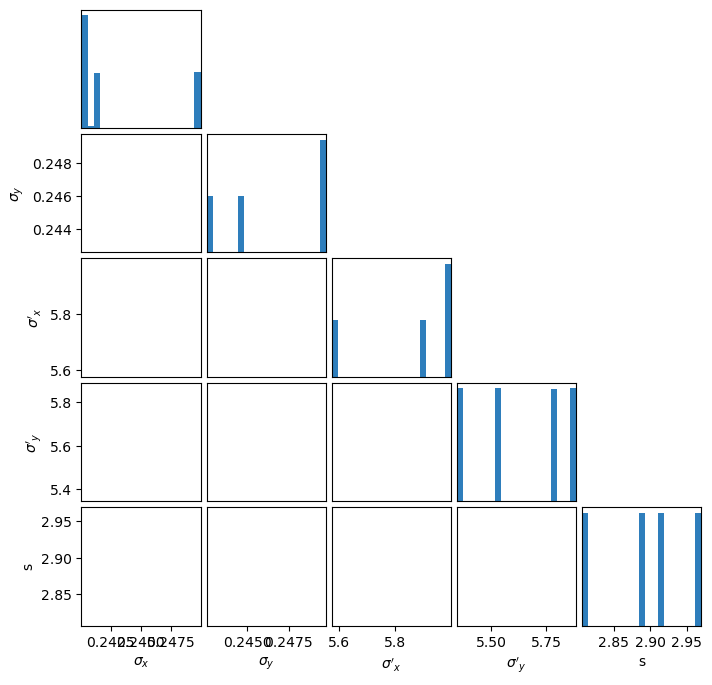

In [66]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [67]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/vhafych/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6332, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 816, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1430, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1501, in _contour_args
    self._process_contour_level_args(args)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1172, in _process_contour_level_args
    raise ValueError("Contour levels must be increasing")


In [68]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/vhafych/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6332, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 816, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1430, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1501, in _contour_args
    self._process_contour_level_args(args)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1172, in _process_contour_level_args
    raise ValueError("Contour levels must be increasing")


In [69]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/vhafych/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6332, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 816, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1430, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1501, in _contour_args
    self._process_contour_level_args(args)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1172, in _process_contour_level_args
    raise ValueError("Contour levels must be increasing")


In [70]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/vhafych/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6332, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 816, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1430, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1501, in _contour_args
    self._process_contour_level_args(args)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1172, in _process_contour_level_args
    raise ValueError("Contour levels must be increasing")


In [71]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/vhafych/.julia/packages/PyCall/BcTLp/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Contour levels must be increasing')
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1438, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 6332, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 816, in __init__
    kwargs = self._process_args(*args, **kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1430, in _process_args
    x, y, z = self._contour_args(args, kwargs)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1501, in _contour_args
    self._process_contour_level_args(args)
  File "/Users/vhafych/.julia/conda/3/lib/python3.8/site-packages/matplotlib/contour.py", line 1172, in _process_contour_level_args
    raise ValueError("Contour levels must be increasing")


In [72]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

LoadError: UndefVarError: generate_event not defined

In [73]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

LoadError: UndefVarError: generate_event not defined

In [74]:
params_array = [param_truth, mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

LoadError: UndefVarError: param_truth not defined

In [ ]:
β = 0.015

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
#         δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         is_ped = [29 .. 35],
#         is_light_f = [1.9 .. 2.3,],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


In [ ]:
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        is_ped = [29 .. 35],
        is_light_f = [1.9 .. 2.3,],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 50..150,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 120
);

algorithm = MetropolisHastings();

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
mode(samples)[1]
 
#2.11452269382

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17,18,19,20,21]
names = dims
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22,23,]
names = dims
# levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# Experiment Event: 

images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)


In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_cam_integral([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [35,35,20,35], 
        μ_y = [35,35,20,35], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# 30 iterationsfro convergence 

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# #40 iterations for convergence 

In [ ]:
β_min = 0.6
β_max = 1.4

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
    
        int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
                β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
                β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
                β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );

# 43 chains for convergence 

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..208,
#     max_nsamples_init = 600,
#     max_nsteps_init = 600,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 1700,
#     max_nsteps_per_cycle = 1700,
#     max_time_per_cycle = Inf,
#     max_ncycles = 60
# );

# nsamples = 6*10^4
# nchains = 4;

In [ ]:
# resolution + prior AWAKE 

β_min = 0.7
β_max = 1.3

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(3.07, 0.5), 0, 5), truncated(Normal(3.95, 0.5), 0, 5), truncated(Normal(2.13, 0.5), 0, 5), truncated(Normal(2.16, 0.5), 0, 5)], 
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [3.07, 3.95, 2.13, 2.16],
        σ_y = [3.07 , 3.95, 2.13, 2.16], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [0, 0, 0, 0],
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


# #40 iterations for convergence 
# res 1: mean([0.0874, 0.0895] ./ [0.0270999, 0.03049999999999997])
#res2: [0.021599999999999397, 0.023400000000000087] ./ [0.0861, 0.0918]
# res 3: mean([0.303, 0.201] ./ [0.11400000000000077, 0.125])
# res4: mean([0.202, 0.189] ./ [0.030303030303030304, 0.02981267596704524] ) / 3

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [Normal(35147.44, β*35147.44), Normal(50235.06, β*50235.06), Normal(10096.64, β*10096.64), Normal(33406.9, β*33406.9)],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );



In [ ]:
# β_min = 0.9
# β_max = 1.1

# prior = NamedTupleDist(
#         tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
#         ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
#         s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
#         μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
#                 β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
#                 β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
#                 β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
#         μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
#                 β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
#                 β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
#                 β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
#         σ_x = [0,0,0,0], 
#         σ_y = [0,0,0,0], 
#         δ_x = [ β_min*param_truth.δ_x[1]..β_max*param_truth.δ_x[1],
#                 β_min*param_truth.δ_x[2]..β_max*param_truth.δ_x[2],
#                 β_min*param_truth.δ_x[3]..β_max*param_truth.δ_x[3],
#                 β_min*param_truth.δ_x[4]..β_max*param_truth.δ_x[4]],
    
#         δ_y = [ β_min*param_truth.δ_y[1]..β_max*param_truth.δ_y[1],
#                 β_min*param_truth.δ_y[2]..β_max*param_truth.δ_y[2],
#                 β_min*param_truth.δ_y[3]..β_max*param_truth.δ_y[3],
#                 β_min*param_truth.δ_y[4]..β_max*param_truth.δ_y[4]],
    
#         int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
#                 β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
#                 β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
#                 β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..200,
#     max_nsamples_init = 2000,
#     max_nsteps_init = 2000,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 5000,
#     max_nsteps_per_cycle = 5000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 45
# );

# algorithm = MetropolisHastings()


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior);

In [ ]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 120..220,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 200
);

algorithm = MetropolisHastings()

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
# BAT.bat_write("test.hdf5", unshaped.(samples))
# CSV.write(SAVE_PATH*file_name_*".csv", output_sp_ms.info)

In [ ]:
# samples = bat_read("../data/sampling_results/Resolution_Effects/wc_resolution.hdf5") 
# samples = varshape(prior).(samples)
# # wcr_samples_uw = bat_sample(wcr_samples, length(wcr_samples)).result;

In [ ]:
# int = bat_integrate(samples)

In [ ]:
mode(samples)[1]

In [ ]:
bat_integrate(samples)

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/wr_px_resolution.hdf5", unshaped.(samples))

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17, 18, 19, 20, 21]
names = ["14", "15", "16", "17", "18", "19", "20", "21"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22, 23, 24, 25, 26, 27, 28, 29]
names = [22, 23, 24, 25, 26, 27, 28, 29]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result ./ length(samples)

In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
@show round.(unshaped(std(samples)), sigdigits=3)

In [ ]:
unshaped(std(samples))

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/w-34d-tmp_resolution.hdf5", unshaped.(samples))

# Whitenig: 

In [ ]:
using MultivariateStats

In [ ]:
resamples = bat_sample(samples, length(samples)).result
flat_samples = collect(flatview(unshaped.(resamples.v)))

W = fit(Whitening, flat_samples)

plt.scatter(flat_samples[1,:], flat_samples[2,:])


In [ ]:
smpl_tr = W.W' * (flat_samples .- W.mean) # white samples
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])


In [ ]:
# min_s = minimum(smpl_tr, dims=2)
# max_s = maximum(smpl_tr, dims=2)

# @show min_s, max_s;

In [ ]:
smpl_tr = inv(W.W')*smpl_tr .+ W.mean # back to original space
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])

In [ ]:
β_min = 0.8
β_max = 1.2

minv = [β_min*param_truth.tr_size[1], β_min*param_truth.tr_size[2], β_min*param_truth.ang_spr[1], β_min*param_truth.tr_size[2], β_min*param_truth.s_waist[1]]
maxv = [β_max*param_truth.tr_size[1], β_max*param_truth.tr_size[2], β_max*param_truth.ang_spr[1], β_max*param_truth.ang_spr[2], β_max*param_truth.s_waist[1]]

prior_samples = rand(Product(Uniform.(minv, maxv)), 10^4)

prior_samples = W.W' * (prior_samples .- W.mean)

min_s = minimum(prior_samples, dims=2)
max_s = maximum(prior_samples, dims=2)

@show round.(min_s, sigdigits=2), round.(max_s, sigdigits=2);


In [ ]:
@show W.W

In [ ]:
@show W.mean

In [ ]:
W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)

In [ ]:
a1, a2, a3, a4, a5 = W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)



In [ ]:
inv(W.W') * [a1, a2, a3, a4, a5] .+ W.mean